In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

In [2]:
class MultiKernelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7]):
        super(MultiKernelConv2d, self).__init__()
        self.branches = nn.ModuleList()
        for kernel_size in kernel_sizes:
            branch = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            self.branches.append(branch)

    def forward(self, x):
        outputs = []
        for branch in self.branches:
            outputs.append(branch(x))
        return torch.cat(outputs, 1)

class CNN(nn.Module):
    def __init__(self, n_classes, img_size):
        super(CNN, self).__init__()
        self.conv1 = MultiKernelConv2d(1, 3)
        self.conv2 = MultiKernelConv2d(9, 3)
        self.fc1 = nn.Linear(3 * 3 * (img_size // 4) * (img_size // 4), 2048)
        self.fc2 = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ApplyMask(nn.Module):
    def __init__(self):
        super(ApplyMask, self).__init__()

    def forward(self, logits, x):
        neighbors = torch.roll(x, shifts=1, dims=2) + \
                    torch.roll(x, shifts=-1, dims=2) + \
                    torch.roll(x, shifts=1, dims=3) + \
                    torch.roll(x, shifts=-1, dims=3)
        mask = ((neighbors > 0) & (x == 0)).reshape(logits.shape)
        masked_logits = torch.where(mask, logits, torch.tensor(-1e9))
        return masked_logits

class CNNWithMask(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNNWithMask, self).__init__()
        self.unet = CNN(n_channels, n_classes)
        self.apply_mask = ApplyMask()

    def forward(self, x):
        logits = self.unet(x)
        logits = self.apply_mask(logits, x)
        return logits

model = CNNWithMask(150*150, 150)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

CNNWithMask(
  (unet): CNN(
    (conv1): MultiKernelConv2d(
      (branches): ModuleList(
        (0): Sequential(
          (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, 

In [4]:
X = []
y = []

for idx, file in tqdm(enumerate(os.listdir('../data'))):
    if file.endswith('.parquet'):
        df = pd.read_parquet(f'../data/{file}')
        X_tmp = df.to_numpy()
        y_tmp = X_tmp[1:] - X_tmp[:-1]
        X_tmp = X_tmp[:-1].reshape(-1, 1, 150, 150)
        random_idx = np.random.choice(X_tmp.shape[0], 10)
        X.extend(X_tmp[random_idx])
        y.extend(y_tmp[random_idx])
    if idx == 100:
        break
    
X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
y = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    
print(X.shape, y.shape)

100it [04:22,  2.62s/it]


torch.Size([1010, 1, 150, 150]) torch.Size([1010, 22500])


In [5]:
model.train();

batch_size = 10
for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    y_batch = y[i:i+batch_size]
    output = model(X_batch)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

5.295007228851318
8.880769729614258
12.254948616027832
11.140443801879883
12.032462120056152
13.045616149902344
16.39408302307129
9.039728164672852
8.96410083770752
7.6684393882751465
9.425021171569824
10.16562557220459
8.020258903503418
8.20947551727295
6.15064001083374
6.856590270996094
6.510179042816162
6.1584601402282715
5.728994846343994
5.948827266693115
6.916079998016357
6.070542335510254
6.352392196655273
5.76751708984375
5.94527006149292
6.17351770401001
5.797694683074951
6.412663459777832
6.579797267913818
5.884971618652344
6.455258369445801
6.581284523010254
6.293128490447998
6.144015789031982
6.415339946746826
6.08762264251709
6.6246538162231445
5.801558971405029
6.122895240783691
-99899998208.0
6.088733673095703
5.58022928237915
5.9033331871032715
5.924886703491211
6.154691219329834
6.650113105773926
6.516731262207031
6.427384853363037
6.5538787841796875
6.415378093719482
5.9430742263793945
6.050736904144287
6.019805908203125
5.740650177001953
6.0852580070495605
5.74964570

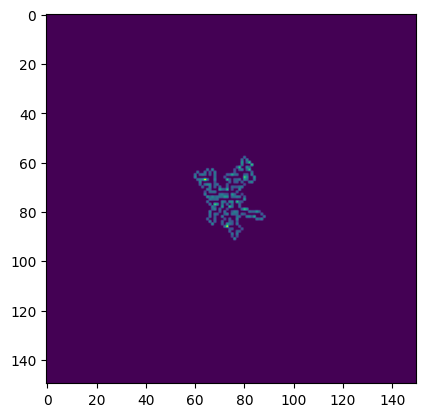

In [12]:
model.eval()

output = F.softmax(model(X[:1]), dim=1)
output = output.detach().cpu().numpy().reshape(150, 150)
plt.imshow(output);